In [1]:
# init things
from sklearn.cluster import KMeans
from scipy.stats import  wishart, dirichlet, invwishart, multivariate_normal
from sklearn.metrics.cluster import adjusted_rand_score as ari
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky
import numpy as np
import plot_hmm
import numba_functions
from numpy.random import binomial
import matplotlib.pyplot as plt

In [2]:
import pickle

# Load state sequence and data from the pickle file
with open('hmm_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Access the loaded data
loaded_ss = loaded_data['state_sequence']
loaded_data = loaded_data['data']
import plot_hmm

init ari 0.341


/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


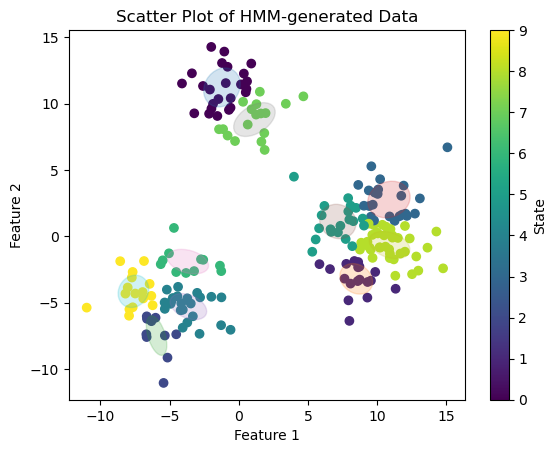

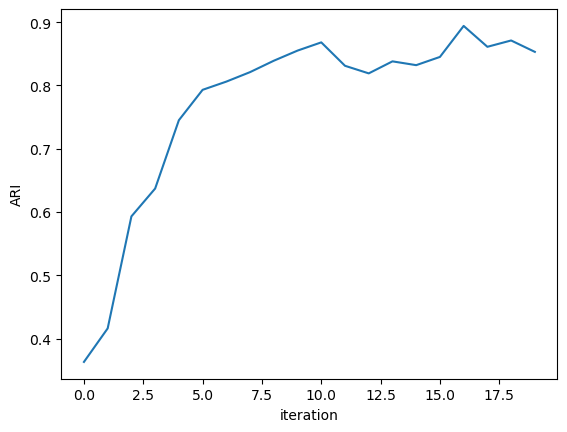

In [3]:
class InfiniteHMM():
    def __init__(self, X, K, Z_true, burn_in=0, iterations=20):
        """
        [] input
        X = data n x d
        K = expected amount of states

        [] params = beta, pi, z, mu, Sigma
        beta ~ GEM(gamma)
        pi ~ DP(beta, k, alpha)
        z ~ HDP()
        mu ~ Gauss(m0, V0)
        Sigma ~ IW(nu0, S0)

        [] hyper-params:
        gamma - concentration for GEM
        alpha - concentration for 2nd GEM
        k - sticky-ness of A

        m0 -> mean of init assignments
        V0 -> large eye matrix
        nu0 -> K + 1
        S0 -> data scatter matrix

        [] ss - need to update probably
        nk - count of data in each k
        x_bar - mean of data in each k
        """

        self.X = X  # data n x d
        self.K = K  # expected / weak limit no of states
        self.burn_in = burn_in
        self.iterations = iterations
        self.N = X.shape[0]     # length of data
        self.D = X.shape[1]     # dimension of data
        self.Z = None
        self.Z_true = Z_true

        # init variables
        self.beta = None    # base gem draw
        self.A = None       # transition matrix
        self.pi = None      # init prob matrix
        self.mu = None      # init mu
        self.sigma = None   # init sigma

        # init hyper-params
        # SDB and sticky-ness
        self.gamma0 = None # concentration param on GEM 1
        self.alpha0 = None # concentration param on GEM 1
        self.k0 = None # sticky-ness
        self.rho0 = None # combination of alpha0 and k0

        # Gaussian mv emission
        self.m0 = None
        self.V0 = None
        self.nu0 = None # Degrees of freedom IW
        self.S0 = None

        # Sufficient statistics, state count and mean
        self.nk = None
        self.x_bar = None
        self.n_mat = None
        self.n_ft = None

        # aux-vars
        self.m_mat = None       # number of tables in restaurant j that were served dish k
        self.m_init = None
        self.w_vec = None       # override variable for table t in restaurant j
        self.m_mat_bar = None   # number of tables in restaurant j that considered dish k

        self.init_sbp()
        self.init_z()

        self.mu_trace = []
        self.sigma_trace = []
        self.pi_trace = []
        self.ARI = np.zeros((self.iterations))
        self.likelihood_history = []

    def init_z(self):

        Z_mat = np.random.multinomial(n=1, pvals=self.pi, size=self.N)
        _, self.Z = np.where(Z_mat == 1) # N x 1 component number

        # true means
        kmeans = KMeans(n_clusters=self.K, random_state=42)
        kmeans.fit(self.X)

        # shuffle labels
        num_labels_to_replace = int(0.05 * len(kmeans.labels_))
        # Generate random labels between 0 and k
        random_labels = np.random.randint(0, self.K, num_labels_to_replace)
        # Replace 10% of the labels with random numbers
        shuffled_labels = np.copy(kmeans.labels_)
        replace_indices = np.random.choice(len(shuffled_labels), num_labels_to_replace, replace=False)
        shuffled_labels[replace_indices] = random_labels
        # Assign the shuffled labels to self.Z
        self.Z = kmeans.labels_
        print('init ari', np.round(ari(self.Z_true, self.Z), 3))

        # sufficient stats
        self.nk = np.zeros(self.K, dtype=int)
        self.x_bar = np.zeros((self.K, self.D), dtype=float)
        for k in range(self.K):
            self.nk[k] = np.sum(self.Z == k)
            self.x_bar[k] = np.mean(self.X[self.Z == k], axis=0)

        # init mu and Sigma
        self.mu = np.zeros((self.K, self.D))
        self.sigma = np.zeros((self.K, self.D, self.D))
        self.lambdas = np.zeros((self.K, self.D, self.D))
        diagsig = np.zeros((self.K, self.D, self.D)) # scatter matrix
        for k in range(self.K):
            x_k = self.X[self.Z == k]
            if len(x_k) < 10:
                random_indices = np.random.randint(0, self.N, int(self.N*0.1))
                x_k = self.X[random_indices]
            sig_bar = np.cov(x_k.T, bias=True)
            diagsig[k] = np.diag(np.diag(sig_bar))
            self.mu[k] = self.x_bar[k]
            self.sigma[k] = sig_bar
            self.lambdas[k] = np.linalg.inv(sig_bar)

        # Hyper-parameters for normals
        # Mu
        self.m0 = np.copy(self.x_bar) # K x D
        if np.isnan(self.m0).any():
            print('nan')
        self.V0 = [np.eye(self.D) * 1000 for _ in range(self.K)] # K x D x D
        # Sigma
        self.S0 = diagsig # K x D x D
        self.nu0 = np.copy(self.K) + 1  # 1 Degrees of freedom IW

    def init_sbp(self):

        self.gamma0 = 50     # concentration parameter for stick breaking
        self.k0 = 0.5         # sticky-ness
        self.alpha0 = 100   # concentration for 2nd stick breaking
        self.rho0 = 0.5 # self.k0/(self.k0+self.alpha0)

        gem_a = np.ones(self.K)*(self.gamma0/self.K) # GEM 1
        gem_a[gem_a<0.01] = 0.01
        self.beta = dirichlet.rvs(gem_a, size=1)[0]  # assume this is a draw from infinite SBP

        gem_b = self.alpha0*self.beta   # + np.identity(L)*rho0; for sticky-ness
        gem_b[gem_b<0.01] = 0.01
        self.A = np.zeros((self.K,self.K))
        for k in range(self.K):
            self.A[k] = dirichlet.rvs(gem_b, size=1)[0]
        self.pi = dirichlet.rvs(gem_b, size=1)[0]

    def sample_z(self):

        backwards = numba_functions.backward_robust_mv(self.A, self.mu, self.sigma, self.X)
        self.Z = numba_functions.sample_states_numba_mv(backwards,
                                     self.pi,
                                     self.X,
                                     self.mu,
                                     self.sigma,
                                     self.A,
                                     self.N)

    def update_ss(self):
        for k in range(self.K):
            self.nk[k] = np.sum(self.Z == k)
            if self.nk[k] > 0:
                self.x_bar[k] = np.mean(self.X[self.Z == k], axis=0)

        # n_mat - count transitions from i to j
        # i = restaurant and j is the dish chosen ?
        n_mat = np.zeros((self.K, self.K))
        for i in range(self.K):
            # find indices of states that come right after state i
            indices = np.where(self.Z == i)[0] + 1  # indices of X_k

            # need to address the case for the last state in the sequence
            if self.N in indices:
                indices = np.delete(indices, np.where(indices == self.N))

            states = self.Z[indices]
            n_i = np.zeros(self.K)
            for j in range(self.K):
                n_i[j] = np.count_nonzero(states == j)
            n_mat[i,:] = n_i
        self.n_mat = n_mat

        # n_ft
        n_ft = np.zeros((self.K))
        n_ft[int(self.Z[0])] += 1
        self.n_ft = n_ft

    def sample_aux_vars(self):
        m_mat = np.zeros((self.K,self.K))

        for j in range(self.K):
            for k in range(self.K):
                if self.n_mat[j,k] == 0:
                    m_mat[j,k] = 0
                else:
                    # pretend multivariate to len(n_mat) at once and avoid loop
                    x_vec = binomial(1, (self.alpha0*self.beta[k]+self.rho0*(j==k))/(np.arange(self.n_mat[j,k])+self.alpha0*self.beta[k]+self.rho0*(j==k)))
                    x_vec = np.array(x_vec).reshape(-1)
                    m_mat[j,k] = sum(x_vec)
        self.m_mat = m_mat

        w_vec = np.zeros(self.K)
        m_mat_bar = m_mat.copy()

        if self.rho0 > 0:
            stick_ratio = self.k0 # rho0/(rho0+alpha0);
            for j in range(self.K):
                if m_mat[j,j]>0:
                    w_vec[j] = binomial(m_mat[j,j], stick_ratio/(stick_ratio+self.beta[j]*(1-stick_ratio)))
                    m_mat_bar[j,j] = m_mat[j,j] - w_vec[j]
        self.w_vec = w_vec
        self.m_mat_bar = m_mat_bar

        # first time point
        m_init = np.zeros(self.K)
        for j in range(self.K):
            if self.n_ft[j] == 0:
                m_init[j] = 0
            else:
                x_vec = binomial(1, self.alpha0*self.beta[j]/(np.arange(self.n_ft[j]) + self.alpha0*self.beta[j]))
                x_vec = np.array(x_vec).reshape(-1)
                m_init[j] = sum(x_vec)

        self.m_init = m_init

    def sample_beta(self):
        prob_vec = self.m_mat_bar.sum(axis=0)+(self.gamma0/self.K)+self.m_init
        prob_vec[prob_vec<0.01] = 0.01
        beta_vec = dirichlet.rvs(prob_vec, size=1)[0]
        self.beta = beta_vec

    def sample_A(self):
        A = np.zeros((self.K,self.K))
        for k in range(self.K):
            prob_vec = (self.alpha0*self.beta)+self.n_mat[k]
            prob_vec[k] += self.rho0
            prob_vec[prob_vec<0.01] = 0.01
            A[k] = dirichlet.rvs(prob_vec, size=1)[0]
        self.A = A

        prob_vec = (self.alpha0*self.beta)+self.n_ft
        prob_vec[prob_vec<0.01] = 0.01
        self.pi = dirichlet.rvs(prob_vec, size=1)[0]

    def sample_theta(self):
        # [1] sample params using assignments
        for k in range(self.K):
            # if count is 0 then don't sample
            if self.nk[k] > 0:
                # mu
                Vk = (np.linalg.inv(np.linalg.inv(self.V0[k]) + self.nk[k] * np.linalg.inv(self.sigma[k])))
                term1 = np.dot(np.linalg.inv(self.sigma[k]), self.nk[k] * self.x_bar[k])
                term2 = np.dot(np.linalg.inv(self.V0[k]), self.m0[k])
                mk = (np.dot(Vk, term1 + term2))
                # sample mu
                mu_k = np.random.multivariate_normal(mean=mk, cov=Vk, size=1).flatten()

                self.mu[k] = mu_k

                # sigma
                dif = (self.X[self.Z == k] - self.mu[k])
                Sk = (self.S0[k] + (np.dot(dif.T, dif)))
                nuk = self.nu0 + self.nk[k]
                # sample sigma
                self.sigma[k] = invwishart.rvs(size=1, df=nuk, scale=Sk)

    def gibbs_sweep(self):
        self.sample_z()
        self.update_ss()
        self.sample_aux_vars()
        self.sample_beta()
        self.sample_A()
        self.sample_theta()

    def fit(self):
        for it in range(self.iterations):
            self.gibbs_sweep()
            # save trace
            # if it > self.burn_in:
            self.mu_trace.append(self.mu)
            self.sigma_trace.append(self.sigma)
            self.pi_trace.append(self.pi)

            # Calculate ARI
            if self.Z_true is not None:
                self.ARI[it] = np.round(ari(self.Z_true, self.Z), 3)

my_hdp_hmm = InfiniteHMM(loaded_data, 10, loaded_ss, iterations=20)
plot_hmm.plot_hmm_data(loaded_data, my_hdp_hmm.Z, my_hdp_hmm.K, my_hdp_hmm.mu, my_hdp_hmm.sigma)
my_hdp_hmm.gibbs_sweep()
my_hdp_hmm.fit()

plt.plot(range(0,len(my_hdp_hmm.ARI)), my_hdp_hmm.ARI, marker="None")
plt.xlabel('iteration')
plt.ylabel('ARI')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()

/Users/david/Documents/mastersCode/ubm/tuts/bhmm/plot_hmm.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse(mu, w, h, theta, color=color, edgecolor='black')  # edgecolor for better visibility


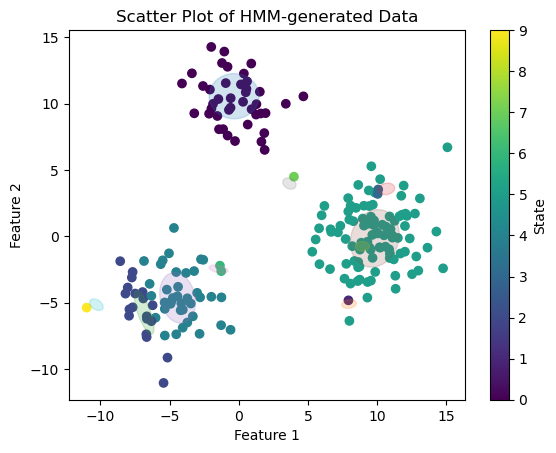

In [5]:
plot_hmm.plot_hmm_data(loaded_data, my_hdp_hmm.Z, my_hdp_hmm.K, my_hdp_hmm.mu, my_hdp_hmm.sigma)